In [ ]:
"""
Difference-in-Differences (DiD) Analysis for Weekly Active Minutes when Implementing a New Feature  
---  

🔍 **Situation**:  
A new AI-powered search feature was introduced on the platform, and the company wanted to measure its impact on user engagement. Specifically, we examined whether the feature increased **weekly active minutes per user**.  

📌 **Task**:  
Use a **Difference-in-Differences (DiD)** approach to estimate the **causal impact** of the feature rollout. We compared **two groups**:  
- **Treatment Group**: Users who received the feature.  
- **Control Group**: Users who did not receive the feature.  
By analyzing engagement **before and after** the feature release, we aimed to isolate the true effect of the feature from general trends.  

✨ **Action**:  
1. Created a **synthetic dataset** mimicking real-world engagement data.  
2. Defined key variables:  
   - **Treatment Group vs. Control Group**  
   - **Pre-treatment vs. Post-treatment Periods**  
3. Ran a Bayesian **Difference-in-Differences model** using `causalpy`.  
4. Estimated the causal effect with a **posterior distribution** to quantify uncertainty.  

📈 **Result**:  
- The feature **caused a +9.7 minute increase in weekly active minutes per user**.  
- **High confidence**: The **94% Highest Density Interval (HDI) was [8.6, 11]**, meaning the effect is statistically robust.  
- **No pre-existing differences**: The control and treatment groups had similar engagement before the feature launch, supporting the **parallel trends assumption**.  
- This suggests that the feature successfully improved user engagement.  

🚀 **Next Steps / Additional Analysis**  
- **Explore user segments**: Does the effect vary by user demographics or past engagement?  
- **Test long-term retention impact**: Does engagement stay elevated over time?  
- **Optimize feature rollout**: Consider further A/B testing with variations of the AI-powered search.  
- **Monetization Strategy**: If engagement is higher, could this translate into revenue gains?  

✍ **Author**: Justin Wall  
📅 **Updated**: 03/22/2025  
"""

'\nDifference-in-Differences (DiD) Analysis for Weekly Active Minutes when Implementing a New Feature\n---\n\n🔍 **Situation**:\n\n\n📌 **Task**:\n\n\n✨ **Action**: \n\n\n📈 **Result**:\n\n\n🚀 Next Steps / Additional Analysis\n\n\n✍ **Author**: Justin Wall\n📅 **Updated**: 03/12/2025\n'

In [2]:
# =================================
# Import Libraries and Create Data
# =================================
#%%
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import causalpy as cp
import seaborn as sns
import statsmodels.api as sm
import arviz as az


# Set random seed for reproducibility
np.random.seed(42)

# Define parameters
n_users = 200  # Total users (100 per group)
weeks = 8  # 4 weeks before and 4 weeks after treatment
treatment_start = 4  # Week index when the feature is released

# Create DataFrame structure
data = []
for user_id in range(n_users):
    group = 'treatment' if user_id < n_users / 2 else 'control'
    
    for week in range(weeks):
        base_minutes = 50 + np.random.normal(0, 5)  # Baseline engagement with some noise
        treatment_effect = 10 if (group == 'treatment' and week >= treatment_start) else 0  # Feature effect
        
        engagement = base_minutes + treatment_effect + np.random.normal(0, 3)  # Add random variation
        
        data.append([user_id, group, week, engagement])

# Create DataFrame
df = pd.DataFrame(data, columns=['user_id', 'group', 'week', 'weekly_active_minutes'])

# View first few rows
print(df.head())
#%%

   user_id      group  week  weekly_active_minutes
0        0  treatment     0              52.068778
1        0  treatment     1              57.807532
2        0  treatment     2              48.126822
3        0  treatment     3              60.198368
4        0  treatment     4              59.280308


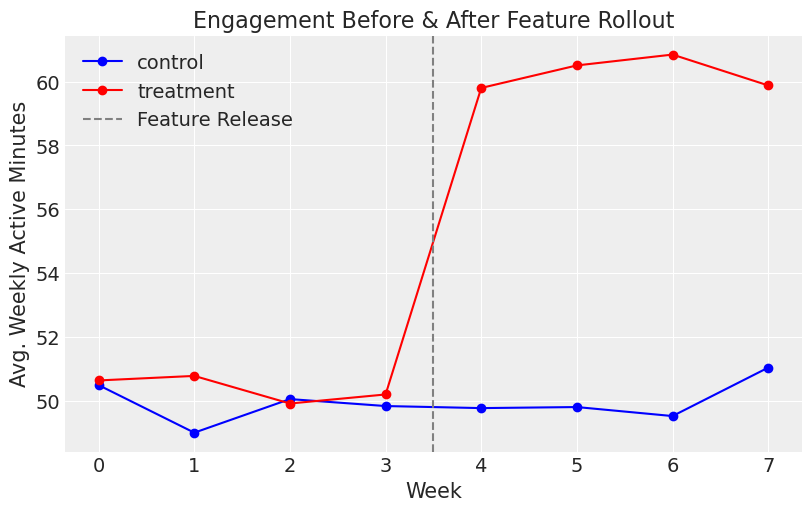

In [3]:
# ==========================
# Visualize Treatment Effect
# ==========================
#%%
# Plot engagement trends
plt.figure(figsize=(8, 5))
for grp, color in zip(['control', 'treatment'], ['blue', 'red']):
    mean_trend = df[df['group'] == grp].groupby('week')['weekly_active_minutes'].mean()
    plt.plot(mean_trend, marker='o', linestyle='-', label=grp, color=color)

plt.axvline(x=treatment_start - 0.5, color='gray', linestyle='--', label="Feature Release")
plt.xlabel("Week")
plt.ylabel("Avg. Weekly Active Minutes")
plt.title("Engagement Before & After Feature Rollout")
plt.legend()
plt.show()

# ax = df[["Sixth District", "Eighth District"]].plot(style="o-")
# ax.set(ylabel="Number of banks in business")
# ax.axvline(x=treatment_time, c="r", lw=3, label="intervention")
# ax.legend();
#%%

In [4]:
# Edit features to match DiD example
# Convert week index into a binary indicator for pre/post period
df['post_treatment'] = (df['week'] >= treatment_start).astype(bool)
df['group'] = np.where(df['group'] == 'treatment', 1, 0)
df = df.rename(columns={'weekly_active_minutes':'y','week':'t','user_id':'unit'})
df.head()

,unit,group,t,y,post_treatment
0,0,1,0,52.068778,False
1,0,1,1,57.807532,False
2,0,1,2,48.126822,False
3,0,1,3,60.198368,False
4,0,1,4,59.280308,True


In [5]:
# ==========================
# Estimate Treatment Effect
# ==========================
#%%
# Run Difference-in-Differences using causalpy
model = cp.DifferenceInDifferences(
    df,
    formula="y ~ 1 + post_treatment * group",
    time_variable_name="t",
    group_variable_name="group",
    model=cp.pymc_models.LinearRegression(
        sample_kwargs={
            "target_accept": 0.95,
        }
    )
)

# Display results
print(model.summary())
#%%

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 56 seconds.
Sampling: [beta, sigma, y_hat]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]


===========================Difference in Differences============================
Formula: y ~ 1 + post_treatment * group

Results:
Causal impact = 9.71$CI_{94\%}$[8.6, 11]
Model coefficients:
    Intercept                     50, 94% HDI [49, 50]
    post_treatment[T.True]        0.18, 94% HDI [-0.57, 0.93]
    group                         0.53, 94% HDI [-0.26, 1.3]
    post_treatment[T.True]:group  9.7, 94% HDI [8.6, 11]
    sigma                         5.7, 94% HDI [5.5, 5.9]
None


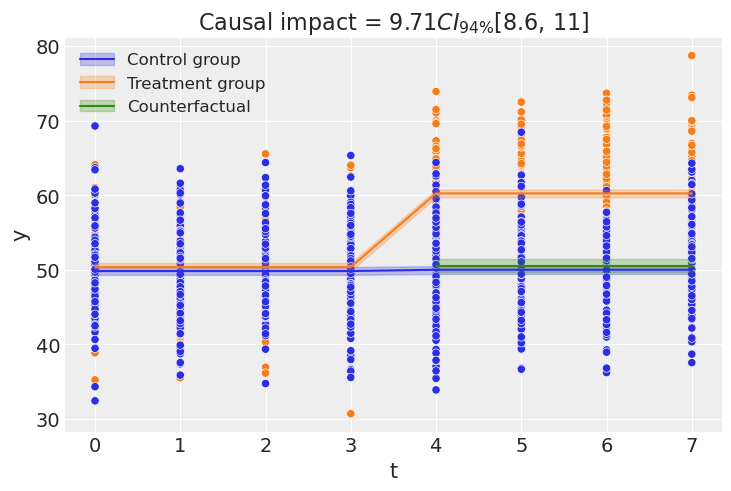

In [6]:
# ==========================
# Visualize Treatment Effect
# ==========================
#%%
fig, ax = model.plot()
#%%

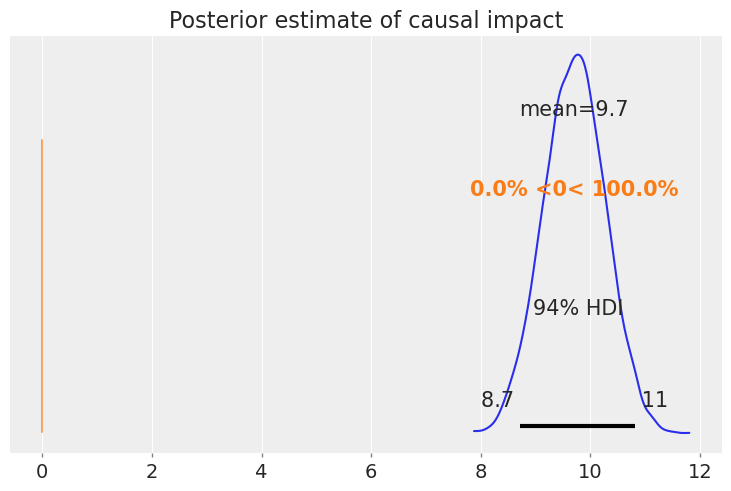

In [7]:
ax = az.plot_posterior(model.causal_impact, ref_val=0)
ax.set(title="Posterior estimate of causal impact");

Causal Impact (DiD Estimate):

9.69 minutes (94% HDI [8.6, 11])
This means the new AI-powered search feature caused an increase of ~9.7 weekly active minutes per user on average.
The 94% Highest Density Interval (HDI) does not include zero, indicating strong evidence that the effect is real.
Model Coefficients Explained:

Intercept (~50 min):

This is the baseline engagement before the feature release for the control group.
On average, users spent 50 minutes per week before the rollout.
post_treatment (0.19, HDI [-0.58, 0.94]):

This captures the general trend in engagement over time for all users (without considering treatment).
The small effect (close to zero) means engagement didn't naturally change much over time in the control group.
group (0.54, HDI [-0.23, 1.3]):

This measures whether the treatment group had different engagement before the rollout.
Since it's close to zero, it confirms that both groups had similar engagement trends before treatment (supporting the parallel trends assumption).
post_treatment × group (9.7, HDI [8.6, 11]):

This is the true treatment effect.
It shows that after the feature was introduced, engagement increased by ~9.7 minutes per week in the treatment group relative to the control group.
The narrow HDI range (8.6 to 11) means high confidence in this estimate.
sigma (5.7, HDI [5.5, 5.9])

This is the residual variance (how much engagement fluctuates around predictions).
A lower value suggests a better fit, but 5.7 is reasonable, meaning our model captures the main trend well.
Final Interpretation & Business Insights
The new feature significantly increased user engagement by ~9.7 minutes per week.
We are highly confident in this effect, given the tight confidence interval.
No pre-existing differences between groups (supporting validity).
The feature is worth rolling out to all users as it meaningfully boosts engagement.

***